# Anomaly Detection on Time Series via Robust Principal Component Analysis

A short introduction on how to apply [Robust Principal Component Analysis (RPCA)][rpca] to detect anomalies on time series. We'll first generate synthetic data to test our implementation of RPCA and go on to apply the same approach to real world ad exchange data taken from the [Numenta Anomaly Benchmark (NAB)][nab].

[rpca]: https://en.wikipedia.org/wiki/Robust_principal_component_analysis
[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/

## Robust Principal Component Analysis

Robust Principal Component Analysis (RPCA) is an extension of PCA, an unsupervised method for dimensionality reduction, widely used in scientific data analytics. While PCA projects the data into a smaller vectorspace along direction of highest variability, RPCA decomposes a $m \times n$ matrix $\mathbf{M}$ as the sum of low-rank component $\mathbf{A}$ (static signal or pattern) and sparse component $\mathbf{E}$ (outliers or temporary artefacts), thus making it _robust_ to outliers.

![rpca components](./rpca.svg)

$$ 
\large \min_{\mathbf{A},\mathbf{E}} \|\mathbf{A}\|_{*} + \lambda \|\mathbf{E}\|_{1}, \quad \text{subject to} \quad \large \mathbf{A} + \mathbf{E} = \mathbf{M}
$$

$ \|\mathbf{A}\|_{*}$ is the nuclear norm, sum of singular values of $\mathbf{A}$

$ \|\mathbf{E}\|_{1}$ is $l_1$-norm, sum of absolute values of elements of $\mathbf{E}$

The solution can be recovered exactly if $\mathbf{A}$ is suffiecently low-rank but not sparse, and if $\mathbf{E}$ is likewise sufficiently sparse but not low-rank (relative to the rank of $\mathbf{A}$).

RPCA is predomanitly applied within computer vision applications (motion detection), where static background (low rank component) is seperated from any novel objects (sparse component). Pictured below is a sequence taken from a CCTV video [[Candes et al. 2009]][Candes2009]. Frames are stacked to each form a row in $\mathbf{M}$ (left). After decomposition we get the static background $\mathbf{A}$ (middle) and any temporary artefacts $\mathbf{E}$ (right).

![Motion Detection](./motion_detection.svg)

---

There are a number of methods to solve the optimization problem above. [Lin et al. (2009)][Lin2009] provide a review including:

* Principcal Component Pursuit
* Iterative Thresholding
* Accelerated Proximal Gradient
* __(Inexact) Augmented Lagrange Multipliers__
* Alternating Direction Method of Multipliers

Here we'll apply the more widely used (next to ADMM) IALM (~5x faster to e.g. APG).

[Candes2009]: http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf


### Augmented Lagrangian Method

Augmented Lagrange Multipliers is a general method for solving constrained optimization problems by replacing unconstrained problems with a series of unconstrained problems, while introducing a penalty to the objective. 

These problems are of the kind:

$$
\large \min f(\mathbf{X}), \quad \text{subject to} \quad h(\mathbf{X})=0 \\
$$

with the Langrangian function defined as:
$$
\large L(\mathbf{X},\mathbf{Y},\mu) = f(\mathbf{X}) + \langle \mathbf{Y},h(\mathbf{X}) \rangle + \frac{\mu}{2} \|h(\mathbf{X})\|^2_F
$$

which we may apply to our problem above, resulting in:

$$ 
\large \mathbf{X} = (\mathbf{A},\mathbf{E}), \quad f(\mathbf{X}) = \|\mathbf{A}\|_* + \lambda \|\mathbf{E}\|_1, \quad h(\mathbf{X}) = \mathbf{M} - \mathbf{A} - \mathbf{E}
\\
\large L(\mathbf{A}, \mathbf{E}, \mathbf{Y}, \mu) ~ \dot = ~ \|\mathbf{A}\|_{*} + \lambda \|\mathbf{E}\|_1 + \langle \mathbf{Y}, \mathbf{M} - \mathbf{A} - \mathbf{E} \rangle + \frac{\mu}{2} \| \mathbf{M} - \mathbf{A} - \mathbf{E} \|^2_{F}
$$

For a more in-depth review, I highly recommend reading through [Lin et al. (2009)][Lin2009].

---

### Algorithm (Inexact Augmented Langrangian Method)

$
\begin{aligned}
&\text{Inputs:} ~ \bf{M}\\
\\
&\text{Initialize:} \\
&\qquad \bf{A} = 0, ~ \bf{E} = 0 \\
&\qquad \bf{Y}, ~ \mu \gt 0 \\
\\
&\text{While not converged do:}\\
&\qquad\bf{U},\bf{S},\bf{V} = \rm{SVD}(\bf{M} - \bf{E} + \bf{Y}/\mu) \\
&\qquad\bf{A} = \bf{U}\it{T}_{1/\mu}(\bf{S})\bf{V}^{\sf{T}} \\
&\qquad\bf{E} = \it{T}_{\lambda/\mu}(\bf{M} - \bf{A} - \bf{Y}/\mu) \\
&\qquad\text{Update} ~ \bf{Y} = \bf{Y} + \mu (\bf{M} - \bf{A} - \bf{E}) \\
\\
&\text{Outputs:} ~ \bf{A}, ~ \bf{E}
\end{aligned}
$


### Typical initialization

$
\begin{aligned}
&sgn(\mathbf{X}) ~ \text{gives sign of each matrix element of} ~ \mathbf{X} \\
\\
&J(\cdot) ~ \text{gives scaling factors:} \\
&\qquad J(\mathbf{X}) = \text{max}(\|\mathbf{X}\|_{\mathrm{2}}, \lambda^{-1} \|\mathbf{X}\|_{\mathrm{∞}}) \\
\\
&\|\mathbf{X}\|_{\mathrm{2}} ~ \textrm{is the spectral norm of matrix} ~ \bf{X} \\
&\|\mathbf{X}\|_{\mathrm{∞}} ~ \textrm{is the largest absolute value of elements of matrix} ~ \bf{X} \\
\\
&\mathbf{Y} = sgn(\mathbf{M})/J(sgn(\mathbf{M})) \\
&\mu = 1.25 ~ \|\bf{M}\|_{\mathrm{2}} \\
&\lambda = 1 / \sqrt{\max{(m, n)}} ~ \text{for} ~ m \times n ~ \text{input matrix} ~
\bf{M}
\end{aligned}
$

#### Reference

$
\begin{aligned}
&T_{\varepsilon}(\mathbf{D}) = \arg \min_{\mathbf{X}} \varepsilon \|\mathbf{X}\|_1 + \frac{1}{2} \|\mathbf{X} - \mathbf{D} \|^2_{F} \\
&\text{with} ~ \mathbf{X} = \mathbf{E}, ~ \mathbf{D} = \mathbf{M} - \mathbf{A} + \mathbf{Y}/\mu \\
&\mathbf{E} = T_{\lambda/\mu}(\mathbf{M} - \mathbf{A} + \mathbf{Y}/\mu)
\end{aligned}
$

---

[Lin2009]: https://arxiv.org/abs/1009.5055

### How does it work?
Decomposition boils down to a minimization problem, we decompose $\mathbf{M}$ into $\mathbf{A}$ and $\mathbf{E}$, where we minimize the rank of $\mathbf{A}$ via its nuclear norm (approximation of matrix rank, can be thought of as convex relaxation of the number of non-zero eigenvalues), and $\mathbf{E}$ is penalized for not being sparse at the same time ($\ell_1$-norm).

### What does this mean for the circumenstances on when we can apply RPCA?
It suffices that the data is composed of largely linearly dependent samples, and defects are rare (well, sparse, though outliers can be of any magnitude in comparision to PCA).

### Implementation

With all that out of the way, implementation is straight forward.

In [1]:
import sys

sys.path.append('./rpca')

In [2]:
# %load ./rpca/algorithm.py
"""
Robust Principal Component Analysis
"""

import numpy as np

from numpy.linalg import norm
from numpy.linalg import svd


def rpca_alm(M, mu=None, l=None, tol=1E-7, max_iter=1000):
    """Matrix recovery/decomposition using Robust Principal Component Analysis
    with Augmented Lagrangian Method (ALM)

    Decompose a rectengular matrix M into a low-rank component, and a sparse
    component, by solving a convex program called Principal Component Pursuit.

    minimize        ||A||_* + λ ||E||_1
    subject to      A + E = M

    where           ||A||_* is the nuclear norm of A (sum of singular values)
                    ||E||_1 is the l1 norm of E (absolute values of elements)

    Parameters
    ----------

    M : array-like, shape (n_samples, n_features)
        Matrix to decompose, where n_samples in the number of samples and
        n_features is the number of features.

    mu : float (default 1.25 * ||M||_2)
        Parameter from the Augmented Lagrange Multiplier form of Principal
        Component Pursuit (PCP). [2]_

    l : float (default 1/sqrt(max(m,n)), for m x n of M)
        Parameter of the convex problem ||A||_* + l ||E||_1. [2]_

    tol : float >= 0 (default 1E-7)
        Tolerance for accuracy of matrix reconstruction of low rank and sparse
        components.

    max_iter : int >= 0 (default 1000)
        Maximum number of iterations to perform.


    Returns
    -------

    A : array, shape (n_samples, n_features)
        Low-rank component of the matrix decomposition.

    E : array, shape (n_samples, n_features)
        Sparse component of the matrix decomposition.

    err : float
        Error of matrix reconstruction

    References
    ----------

    .. [1] Z. Lin, M. Chen, Y. Ma. The Augmented Lagrange Multiplier Method for
           Exact Recovery of Corrupted Low-Rank Matrices, arXiv:1009.5055

    .. [2] E. J. Candés, X. Li, Y. Ma, J. Wright. Robust principal
           component analysis? Journal of the ACM v.58 n.11 May 2011

    """

    rho = 1.5

    if not mu:
        mu = 1.25 * norm(M, ord=2)

    mutol = 1E7

    if not l:
        l = np.max(M.shape)**-0.5

    M_sign = np.sign(M)
    norm_spectral = norm(M_sign, ord=2)
    norm_inf = norm(M_sign, ord=np.inf) * (l**-1)
    norm_dual = np.max([norm_spectral, norm_inf * l**-1])

    Y = M_sign * norm_dual**-1
    A = np.zeros(M.shape)
    E = np.zeros(M.shape)

    err = np.inf
    i = 0

    while err > tol and i < max_iter:
        U, S, V = svd(M - E + Y * (mu**-1), full_matrices=False)

        A = np.dot(U, np.dot(np.diag(_shrink(S, mu**-1)), V))
        E = _shrink(M - A + Y * (mu**-1), l * mu**-1)
        Y = Y + mu * (M - A - E)

        err = _fro_error(M, A, E)
        mu *= rho
        mu = np.min([mu, mutol])
        i += 1

    return A, E, err


def _fro_error(M, A, E):
    """Error of matrix reconstruction"""
    return norm(M - A - E, ord='fro') / norm(M, ord='fro')


def _shrink(M, t):
    """Shrinkage operator"""
    return np.sign(M) * np.maximum((np.abs(M) - t), np.zeros(M.shape))


### Wrapping into Sci-Kit Transformer

While we're at it, we're going to wrap our function into the sci-kit transformer base class, which will come in handy building pipelines in the future. This will serve only as quick scaffolding, to get us started and not something we want to run in production.

In [3]:
# %load ./rpca/transformer.py
"""
Robust Principal Component Analysis Scikit-Learn transformer
"""

from sklearn.base import TransformerMixin

from algorithm import rpca_alm


class RobustPCA(TransformerMixin):
    """Robust Principal Component Analysis with Augmented Lagrangian Method

    Decompose a rectengular matrix M into a low-rank component, and a sparse
    component, by solving a convex program called Principal Component Pursuit.

    minimize        ||A||_* + λ ||E||_1
    subject to      A + E = M

    where           ||A||_* is the nuclear norm of A (sum of singular values)
                    ||E||_1 is the l1 norm of E (absolute values of elements)

    Parameters
    ----------

    method : string {sparse, low_rank}
        sparse: Transformation will yield the sparse component
        low_rank: Transformation will yield the low-rank component

    mu : float (default 1.25 * ||M||_2)
        Parameter from the Augmented Lagrange Multiplier form of Principal
        Component Pursuit (PCP). [2]_

    l : float (default 1/sqrt(max(m,n)), for m x n of M)
        Parameter of the convex problem ||A||_* + l ||E||_1. [2]_

    tol : float >= 0 (default 1E-7)
        Tolerance for accuracy of matrix reconstruction of low rank and sparse
        components.

    max_iter : int >= 0 (default 1000)
        Maximum number of iterations to perform.

    Attributes
    ----------

    low_rank_ : array, (n_samples, n_features)
        Low-rank component of the matrix decomposition.

    sparse_ : array, (n_samples, n_features)
        Sparse component of the matrix decomposition.

    error_ : float
        Error of matrix reconstruction


    References
    ----------

    .. [1] Z. Lin, M. Chen, Y. Ma. The Augmented Lagrange Multiplier Method for
           Exact Recovery of Corrupted Low-Rank Matrices, arXiv:1009.5055

    .. [2] E. J. Candés, X. Li, Y. Ma, J. Wright. Robust principal
           component analysis? Journal of the ACM v.58 n.11 May 2011

    """

    def __init__(self, method='sparse',
                 mu=None,
                 l=None,
                 tol=1E-7,
                 max_iter=1000):

        options = ['sparse', 'low_rank']

        if method not in options:
            raise ValueError(f'method must be one of {options}')

        self._method = method
        self._mu = mu
        self._l = l
        self._tol = tol

        self.low_rank_ = None
        self.sparse_ = None

    def transform(self, X):
        """Matrix decomposition/recovery with RPCA and ALM

        Parameters
        ----------

        X : array-like, shape (n_samples, n_features)
            Matrix to decompose, where n_samples in the number of samples and
            n_features is the number of features.

        Returns
        -------

        X_new : array-like, shape (n_samples, n_features)
            Decomposed matrix, either sparse component (method `sparse`) or
            low-rank component (method `low_rank`)
        """
        self.low_rank_, self.sparse_, self.error_ = rpca_alm(X,
                                                             mu=self._mu,
                                                             l=self._l,
                                                             tol=self._tol)
        if self._method == 'sparse':
            return self.sparse_
        elif self._method == 'low_rank':
            return self.low_rank_
        else:
            raise ValueError('unknown method')


## Testing on synthetic data

Since RPCA is an unsupervised method, we'll have a hard time finding an annotated data set we could run our implementation against ([NAB][nab] is such a framework, but targets a more wholesome approach to outlier/novelty detection). For our purpose what we want is a time series with known anomalies that present a challenge for conventional approaches to detect these. 

What are non-trivial challenges for threshold/average based methods for outlier detection without preprocessing or smoothing the signal?

* seasonality
* trend
* noise

Ideally our test series would have some sort of seasonal recurring characteristic. We could think of this as any metric that is correlated to the time of day, similar to water consumption throughout the day, sales/traffic in region.

[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'pdf'

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [6]:
try:
    plt.style.use('markow')
except:
    plt.style.use('ggplot')

PLTARGS = {'figsize': (12, 6)}

In [7]:
N_SAMPLES = 100
FREQUENCY = 3

pattern = np.array([np.sin(2.0 * np.pi * FREQUENCY * N_SAMPLES**-1 * n) for n in range(N_SAMPLES+1)])

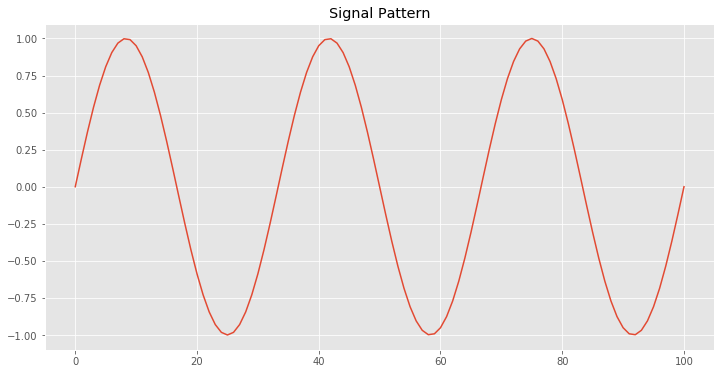

In [8]:
plt.figure(**PLTARGS)
plt.title('Signal Pattern')
plt.plot(pattern);

Voila, a sinusoidal signal.

We'll have to deal with noisy signals, so we're going to add a bit gaussian noise. In addition we modulate the amplitude and randomly shift the mean of each sample, to showcase we only need the resulting matrix of our stacked dummy signals to be suffiecently low rank (linear dependent row vectors).

Since we want to be able to reproduce our setup in the future we're going to fix it (seeding random number generator). Everytime one runs our notebook it'll yield the same output. 

In [9]:
np.random.seed(seed=456733626)

In [10]:
N_SENSORS = 100
AMPLITUDE = (10, 40)
YSHIFT = (50, 100)
SIGMA = 3
MU = 0

gauss_range = lambda x: np.random.rand() * (x[1]-x[0]) + x[0]

sensors = np.zeros((N_SENSORS, N_SAMPLES+1))

for i in range(N_SENSORS):
    noise = np.random.randn(N_SAMPLES+1) * SIGMA + MU
    signal = pattern * gauss_range(AMPLITUDE) + gauss_range(YSHIFT)
    sensors[i,:] = np.add(signal, noise)
    
sensor_names = np.array([f'sensor{n:03}' for n in range(1, N_SENSORS+1)])
    
df_sensors = pd.DataFrame(sensors.T, columns=sensor_names)

In [11]:
df_sensors.shape

(101, 100)

In [12]:
df_sensors.head(3)

,sensor001,sensor002,sensor003,sensor004,sensor005,sensor006,sensor007,sensor008,sensor009,sensor010,...,sensor091,sensor092,sensor093,sensor094,sensor095,sensor096,sensor097,sensor098,sensor099,sensor100
0,57.669753,55.402151,82.059911,101.330584,72.193168,76.323176,67.939596,55.209994,94.401344,63.896688,...,78.370841,51.074473,66.572422,82.071946,76.488259,61.076351,85.582060,73.741268,83.936137,59.517250
1,70.311771,52.085679,90.414549,104.836928,77.066970,81.631386,65.517215,55.104898,100.779719,69.845241,...,87.206179,60.980816,75.009266,89.267616,79.377751,67.464724,95.259478,74.283086,86.982747,64.620717
2,72.548859,58.951096,91.945815,109.998149,79.623673,98.080501,72.742849,56.607973,107.315154,74.671570,...,93.660543,57.301636,77.096759,89.065491,81.528715,73.127496,106.216898,77.758512,94.061979,65.970785


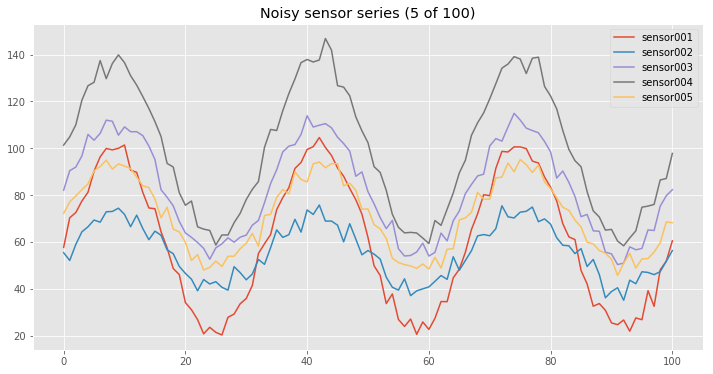

In [13]:
df_sensors.iloc[:, :5].plot(title='Noisy sensor series (5 of 100)', **PLTARGS);

To not only filter the noise, we need to introduce some defects (anomalies).
Anomalies come in all kinds of shapes. Like with any ML approach, there's unlikely a method which outperforms all others in all scenarios. We have to consider where RPCA shines, and where it doesn't. It's particular good at finding deviations from an underlying, shared pattern. So we're going to introduce exactly that, short lived deviations from our base pattern. 

In [14]:
ANOMALY_DURATION = 10
ANOMALY_INTENSITY = 10

anomaly_map = np.random.rand(N_SENSORS) < 0.1

anomalies = np.zeros((N_SENSORS, N_SAMPLES+1))

for i, malign in enumerate(anomaly_map):
    if malign:
        onset = np.random.randint(N_SAMPLES - ANOMALY_DURATION)
        sign = -1 if np.random.randn() < 0.5 else 1
        noise = np.random.normal(0, 1, ANOMALY_DURATION) + ANOMALY_INTENSITY
        anomalies[i, onset:onset+ANOMALY_DURATION] = sign * noise

df_anomalies = pd.DataFrame(anomalies.T, columns=sensor_names)

In [15]:
df_anomalies.shape

(101, 100)

In [16]:
samples = np.where(anomaly_map)[0][:3]
print(sensor_names[samples])

['sensor002' 'sensor003' 'sensor011']


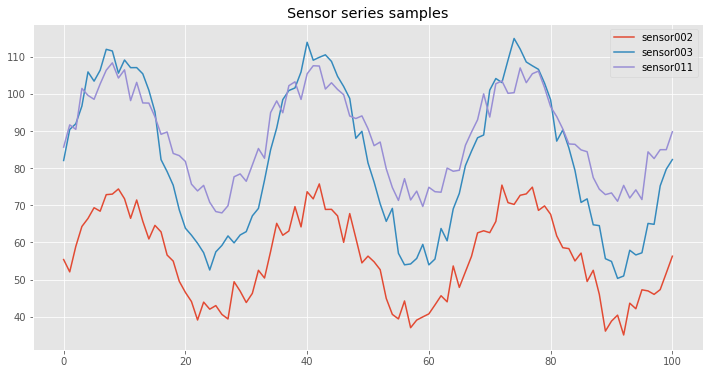

In [17]:
df_sensors.iloc[:, samples].plot(title='Sensor series samples', **PLTARGS);

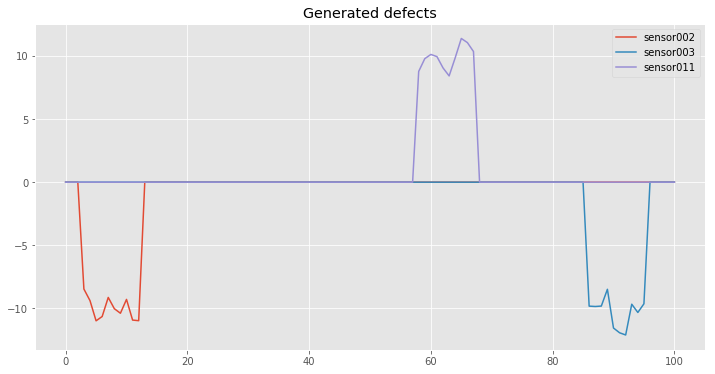

In [18]:
df_anomalies.iloc[:, samples].plot(title='Generated defects', **PLTARGS);

In [19]:
df_sensors_with_anomalies = df_sensors + df_anomalies

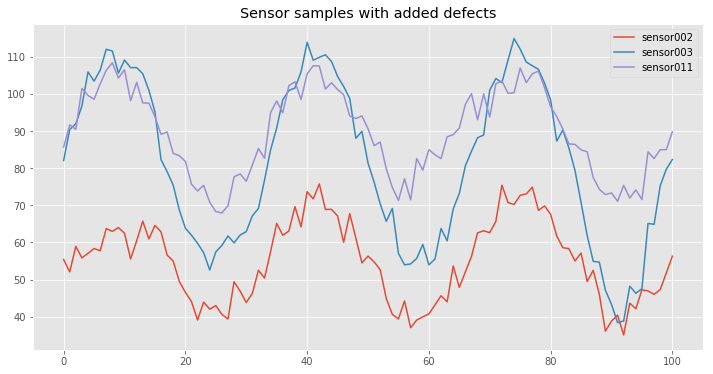

In [20]:
df_sensors_with_anomalies.iloc[:, samples].plot(title='Sensor samples with added defects', **PLTARGS);

In [21]:
val = StandardScaler(with_mean=True, with_std=False).fit_transform(df_sensors_with_anomalies.values.T)

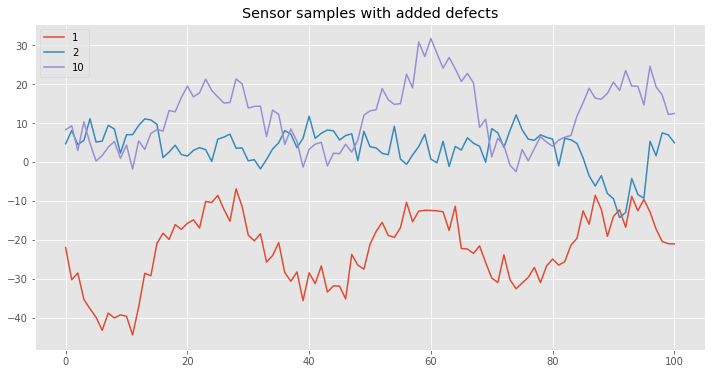

In [22]:
pd.DataFrame(val.T).iloc[:, samples].plot(title='Sensor samples with added defects', **PLTARGS);

In [23]:
model = RobustPCA(method='sparse', max_iter=10000)

In [24]:
%%time

sparse_matrix = model.transform(val)

CPU times: user 11.1 ms, sys: 2.57 ms, total: 13.6 ms
Wall time: 11.9 ms


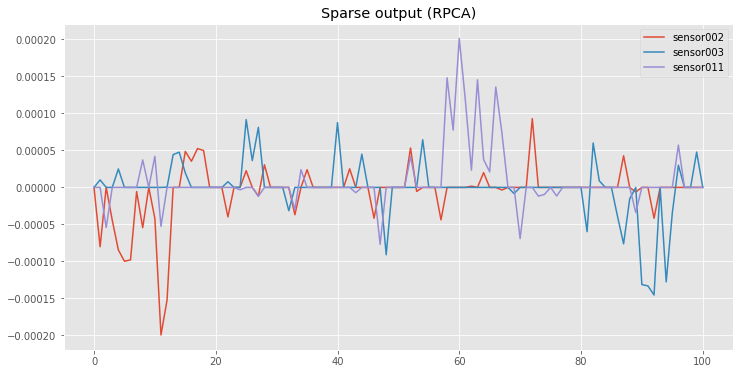

In [25]:
df_anomalies_estimated = pd.DataFrame(sparse_matrix.T, columns=sensor_names)
df_anomalies_estimated.iloc[:, samples].plot(title='Sparse output (RPCA)', **PLTARGS);

In [26]:
mean = np.mean(df_anomalies_estimated.values)
std = np.std(df_anomalies_estimated.values)

In [27]:
df_anomalies_zscore = (df_anomalies_estimated - mean) / std

In [28]:
THRESHOLD = 3

df_outliers = df_anomalies_zscore[(df_anomalies_zscore >= THRESHOLD) | (df_anomalies_zscore <= -THRESHOLD)]

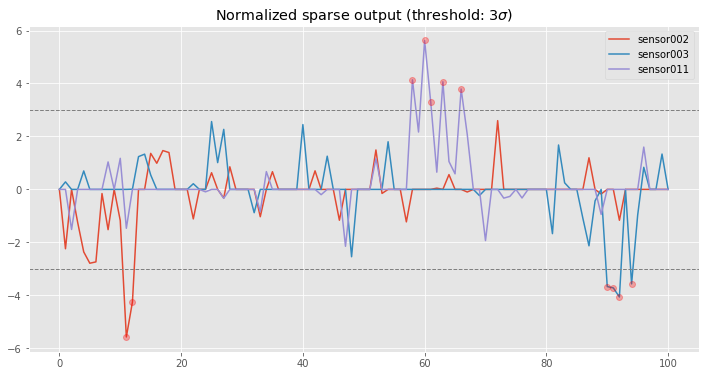

In [29]:
ax = df_anomalies_zscore.iloc[:, samples].plot(title=f'Normalized sparse output (threshold: ${THRESHOLD}\sigma$)', 
                                               **PLTARGS)
ax.axhline(y=THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
ax.axhline(y=-THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
df_outliers.iloc[:, samples].plot(ax=ax, legend=False, linestyle='none', color='r', marker="o", alpha=.3);

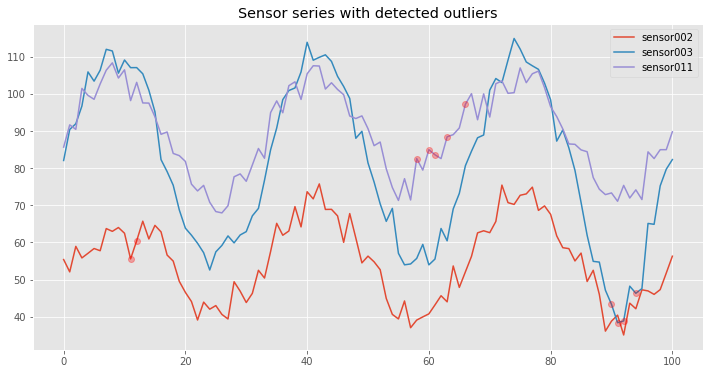

In [30]:
ax = df_sensors_with_anomalies.iloc[:, samples].plot(title='Sensor series with detected outliers', **PLTARGS)
df_sensors_with_anomalies[df_outliers.iloc[:, samples].isnull() == False].plot(ax=ax, legend=False, linestyle='none',
                                                                               color='r', marker="o", alpha=.3);

## Evaluating on historic ad exchange data

* https://github.com/numenta/NAB
* https://github.com/numenta/NAB/blob/master/data/realAdExchange/exchange-2_cpm_results.csv

In [31]:
!head -n 5 data/exchange-2_cpm_results.csv | tr ',' '\t'

timestamp	value
2011-07-01 00:00:01	0.401048098657
2011-07-01 01:00:01	0.392718881005
2011-07-01 02:00:01	0.309996119798
2011-07-01 03:00:01	0.212938552018


In [32]:
df_cpm = pd.read_csv('data/exchange-2_cpm_results.csv', index_col='date', names=['date', 'cpm'],
                     sep=',', parse_dates=True, header=0)

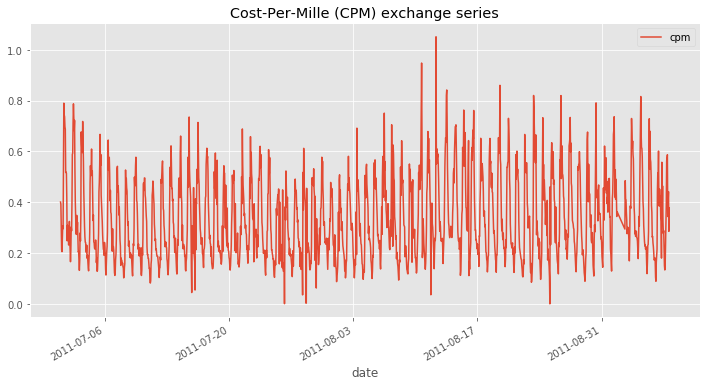

In [33]:
df_cpm.plot(title='Cost-Per-Mille (CPM) exchange series', **PLTARGS);

In [34]:
!sed -n '1500,1515p' data/exchange-2_cpm_results.csv | tr ',' '\t'

2011-09-01 14:00:01	0.412298289967
2011-09-01 15:00:01	0.490840855649
2011-09-01 16:00:01	0.428572872891
2011-09-01 17:00:01	0.344159041135
2011-09-01 18:00:01	0.362985835006
2011-09-02 15:00:01	0.29474600602
2011-09-02 16:00:01	0.485279887016
2011-09-02 17:00:01	0.41176305761
2011-09-02 18:00:01	0.410321629465
2011-09-02 19:00:01	0.361436552275
2011-09-02 20:00:01	0.330957212541
2011-09-02 21:00:01	0.276432333565
2011-09-02 22:00:01	0.291694292981
2011-09-02 23:00:01	0.301794690505
2011-09-03 00:00:01	0.291617242099
2011-09-03 01:00:01	0.277953194651


In [35]:
df_cpm = df_cpm.resample('1h').mean()

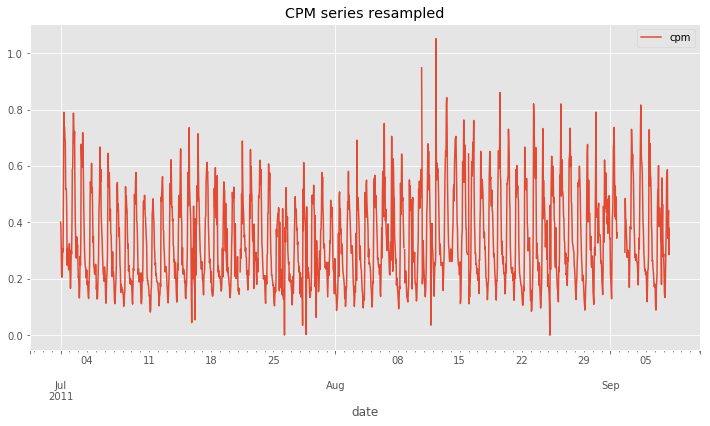

In [36]:
df_cpm.plot(title='CPM series resampled', **PLTARGS);

In [37]:
df_cpm = df_cpm.interpolate(method='linear')

In [38]:
df_cpm['week'] = df_cpm.index.weekofyear
df_cpm['day'] = df_cpm.index.dayofweek
df_cpm['hour'] = df_cpm.index.hour

df_cpm_by_week = pd.pivot_table(df_cpm, index=['day', 'hour'], columns=['week'], values='cpm',
                           aggfunc=np.mean)

In [39]:
df_cpm_by_week.shape

(168, 11)

In [40]:
df_cpm_by_week.isnull().sum().sum()

200

In [41]:
df_cpm_by_week.isnull().sum()

week
26     96
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36    104
dtype: int64

In [42]:
df_cpm_by_week = df_cpm_by_week.dropna(axis=1, how='any')

In [43]:
df_cpm_by_week.shape

(168, 9)

In [44]:
df_cpm_by_week.isnull().sum().sum()

0

In [45]:
df_cpm_by_week.head()

week            27        28        29        30        31        32  \
day hour                                                               
0   0     0.179942  0.139389  0.225183  0.178073  0.183855  0.158421   
    1     0.192673  0.140955  0.161582  0.135347  0.146499  0.147071   
    2     0.166335  0.092254  0.150193  0.114143  0.136459  0.121540   
    3     0.142272  0.082216  0.138530  0.104570  0.087786  0.093912   
    4     0.130355  0.090850  0.139423  0.144247  0.113553  0.125770   

week            33        34        35  
day hour                                
0   0     0.219272  0.151385  0.148677  
    1     0.259993  0.136277  0.122675  
    2     0.112466  0.110605  0.109182  
    3     0.129890  0.106407  0.089285  
    4     0.184369  0.123629  0.124575

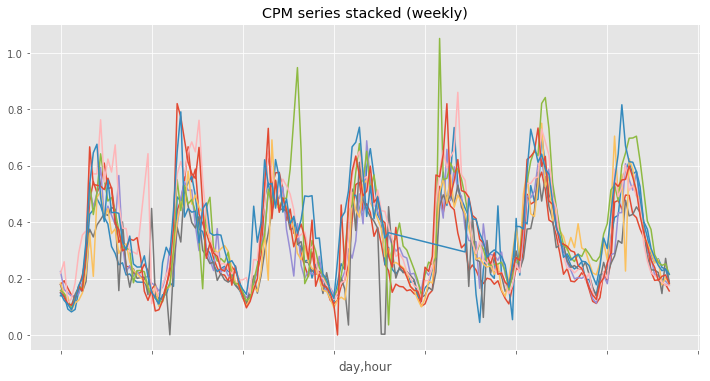

In [46]:
df_cpm_by_week.plot(title='CPM series stacked (weekly)', legend=False, **PLTARGS);

In [47]:
#df_cpm_by_week.T.to_csv('./data/cpm_weekly_clean.csv', header=False, index=False)

In [48]:
val = StandardScaler(with_mean=True, with_std=False).fit_transform(df_cpm_by_week.values)

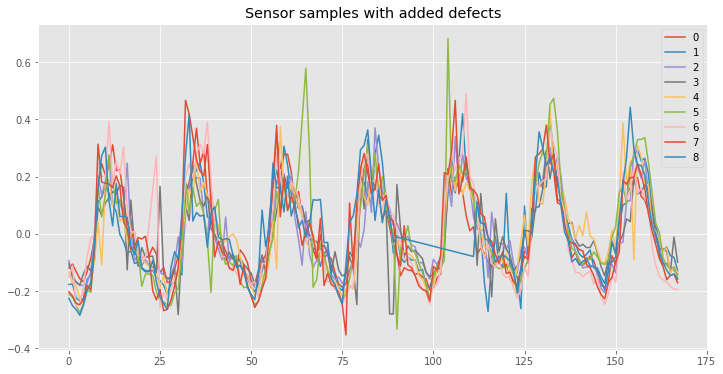

In [49]:
pd.DataFrame(val).plot(title='Sensor samples with added defects', **PLTARGS);

In [50]:
%%time

cpm_sparse = model.transform(val)

CPU times: user 5.07 ms, sys: 937 µs, total: 6.01 ms
Wall time: 5.22 ms


In [51]:
cpm_mean = np.mean(cpm_sparse)
cpm_std = np.std(cpm_sparse)

cpm_sparse_zscore = (cpm_sparse - cpm_mean) / cpm_std

df_cpm_anomalies = pd.DataFrame(cpm_sparse_zscore, columns=df_cpm_by_week.columns, index=df_cpm_by_week.index)

In [52]:
THRESHOLD = 3

df_cpm_outliers = df_cpm_anomalies[(df_cpm_anomalies >= THRESHOLD) | (df_cpm_anomalies <= -THRESHOLD)]

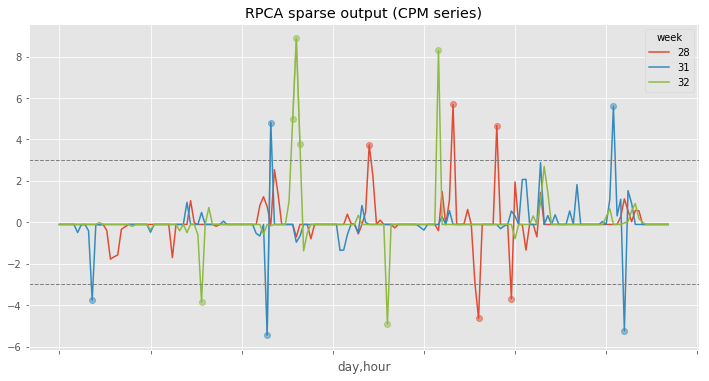

In [53]:
selected_weeks = [28, 31, 32]
colors = ['C0', 'C1', 'C5']

ax = df_cpm_anomalies[selected_weeks].plot(color=colors, **PLTARGS)
ax.axhline(y=THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
ax.axhline(y=-THRESHOLD, color='.5', linestyle='--', linewidth=1.0)
df_cpm_outliers[selected_weeks].plot(title='RPCA sparse output (CPM series)', ax=ax, marker='o', color=colors,
                                     alpha=.5, linestyle=None, label='outlier', legend=False);

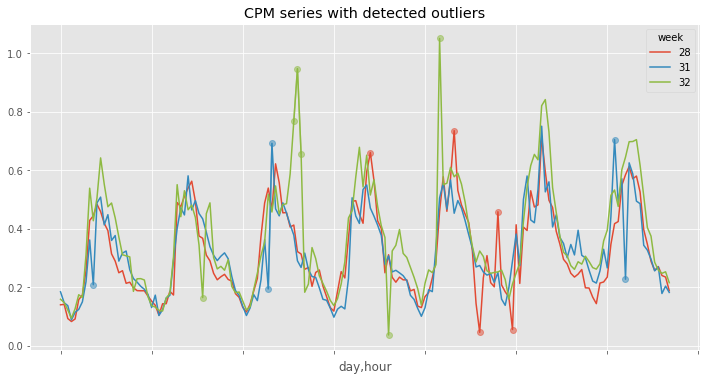

In [54]:
ax = df_cpm_by_week[selected_weeks].plot(color=colors, **PLTARGS)
df_cpm_by_week[df_cpm_outliers.isnull() == False][selected_weeks].plot(title='CPM series with detected outliers',
                                                                       ax=ax, marker='o', color=colors, alpha=.5, 
                                                                       linestyle=None, legend=False);

## Conclusion


### Where to go from here?

* online version
* stochastic version

## References

* Candès et al. (2009) [Robust Principal Component Analysis?][Candes2009]
* Lin et al. (2009) [The Augmented Lagrange Multiplier Method for Exact Recovery
  of Corrupted Low-Rank Matrices][Lin2009]
* [Anomaly Detection: Numenta Anomaly Benchmark][nab]


[Candes2009]: http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf
[Lin2009]: https://arxiv.org/abs/1009.5055
[nab]: https://numenta.com/applications/numenta-anomaly-benchmark/